# Import Libraries 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 13 13:07:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
import os
# seed = 0
# os.environ['PYTHONHASHSEED']=str(seed)


In [ ]:
import pandas as pd
import numpy as np
import cv2
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import random as rn
from sklearn.preprocessing import  StandardScaler
# import sys
# !{sys.executable} -m pip install torchvision

In [ ]:
# import sys    
# !{sys.executable} -m pip install hypopt

In [ ]:
import tensorflow as tf

# tf.enable_eager_execution()
# tf.config.run_functions_eagerly(True)
# tf.compat.v1.enable_eager_execution()
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten , Input ,BatchNormalization, Concatenate, Layer , Maximum , Softmax
from tensorflow.keras.layers import  GlobalAveragePooling2D, AveragePooling2D , Conv1D , MaxPooling1D, Average, Dropout, LayerNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, GRU, ReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,balanced_accuracy_score
import joblib

# from keras.applications import vgg16
# from keras.applications.efficientnet import EfficientNetB3 



In [ ]:
# from catboost import CatBoostClassifier
# from xgboost import XGBClassifier

# import pytorch_tabnet
# from pytorch_tabnet.tab_model import TabNetClassifier
# import torch
import sklearn

# Some Functions 

In [ ]:
# print(np.__version__)
# print(pd.__version__)
# print(cv2.__version__)
# # print(plt.__version__)
# print(sklearn.__version__)
# print(tf.__version__)
# print(keras.__version__)

In [ ]:
def take_f1_Score(y_pred, y_test) :
  k = list(f1_score(y_pred, y_test, average=None))
  ds = []
  for i in range(len(k)):
    kk = round(k[i]*100, 2)
    ds.append(kk)
  print(ds)

In [ ]:
def draw_cm (y_true,y_pred):
  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_true, y_pred,normalize = 'true')
  ds = []
  for i in range(len(cm)):
    kk = round(cm[i][i], 4)
    ds.append(kk)
  cm_df = pd.DataFrame(cm,
                      index = [       '?????' ,
                                      'Falling hands' ,
                                      'Falling knees' ,
                                      'Falling backwards',
                                      'Falling sideward' ,
                                      ' Falling chair',
                                      ' Walking',
                                      'Standing' ,
                                      'Sitting' ,
                                      'Picking object' ,
                                      'Jumping' ,
                                      'Laying' ], 
                      columns = [       '?????' ,
                                      'Falling hands' ,
                                      'Falling knees' ,
                                      'Falling backwards',
                                      'Falling sideward' ,
                                      ' Falling chair',
                                      ' Walking',
                                      'Standing' ,
                                      'Sitting' ,
                                      'Picking object' ,
                                      'Jumping' ,
                                      'Laying' ])


  import seaborn as sns
  sns.color_palette("tab10")
  #Plotting the confusion matrix
  plt.figure(figsize=(10,10))
  sns.heatmap(cm_df, annot=True,fmt='.2%', cmap='gist_stern_r')
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()
# plt.savefig('confusion.png')
  return ds


In [ ]:

def model_1concat_gating(shape1, shape2 , all_list_filters, list_num_experts, same_seed = True):


    def set_seed(num_seed): 
        SEED = num_seed 
        os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
        
        

        
    def expert_block(inputs , num_filters,  num_seed):
        set_seed(num_seed)
        conv = Conv2D(filters = num_filters[0],
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        conv = MaxPooling2D(pool_size=(2, 2))(conv)
        conv = BatchNormalization()(conv)
        if  1 <= len(num_filters[1:]) <= 3  :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = MaxPooling2D(pool_size=(2, 2))(conv)
                conv = BatchNormalization()(conv)
        elif len(num_filters[1:]) >= 4 :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = BatchNormalization()(conv)

            
        #-------------------------------------------------- 
        conv = Flatten()(conv)
        conv = Dense(units =  1000,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        #-----------------------------         
        conv = Dense(units =  600,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        conv = Dropout(rate = 0.2)(conv)
        y_hat = Dense(units = 12,
                      activation = None)(conv)
        return y_hat
    
    def Mixture_of_Experts(inputs,list_num_filters , num_experts, names) :
        assert len(list_num_filters) == num_experts
        num_seed = 0
        expert_outs = []
        for i in range(num_experts):
            if same_seed :
                expert_network = expert_block(inputs, list_num_filters[i], num_seed )
            else :
                expert_network = expert_block(inputs, list_num_filters[i], i )
            expert_outs.append(expert_network)
        expert_concat = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1))(expert_outs)
        print('expert concat shape : ', expert_concat.shape)
        # gating network 
        gating = Conv2D(filters = 30,
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        gating = MaxPooling2D(pool_size=(2, 2))(gating)
        gating = BatchNormalization()(gating)
        gating = Flatten()(gating)
        # ------------------------------------------------
        gating = Dense(800, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(1200, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(num_experts, activation = tf.nn.softmax)(gating)
        gating = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(gating)
        gate_mul_expert = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x[0] * x[1], axis=1),
                                                 name='gate_mul_expert_' + names )([expert_concat, gating])
        gate_mul_expert = tf.keras.layers.Softmax()(gate_mul_expert)
        print('gate mul expert : ', gate_mul_expert.shape)

        return gate_mul_expert
    
    assert len(all_list_filters) == list_num_experts
    names = '0'
    set_seed(0)
    #------------------------------------------
    input = Input(shape = (shape1, shape2, 1))
    output = Mixture_of_Experts(input, all_list_filters , list_num_experts,names)
    #------------------------------------------
#     concat = Concatenate(axis=1)([MoE_1, MoE_2, MoE_3])
#     concat = Dense(units = 600,
#                    activation = tf.nn.relu)(MoE_1)
#     concat = BatchNormalization()(concat)
#     concat = Dropout(0.25)(concat)
#     concat = Dense(units = 1000 ,
#                    activation = tf.nn.relu)(concat)
#     concat = BatchNormalization()(concat)
#     concat = Dropout(0.25)(concat)
#     softmax = Dense(12, activation = tf.nn.softmax )(concat)



    
    model = Model(inputs=[input], outputs=output)
    return model


In [ ]:
def model_2concat_gating(shape1, shape2 , all_list_filters_0, all_list_filters_1, list_num_experts_0, list_num_experts_1, 
                         same_seed = [True,True], method = 'concat'):
    
    def set_seed(num_seed): 
        SEED = num_seed 
        # os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        # session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        # sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        # tf.compat.v1.keras.backend.set_session(sess)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
        
    def expert_block(inputs , num_filters,  num_seed):
        set_seed(num_seed)
        conv = Conv2D(filters = num_filters[0],
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        conv = MaxPooling2D(pool_size=(2, 2))(conv)
        conv = BatchNormalization()(conv)
        if  1 <= len(num_filters[1:]) <= 3  :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = MaxPooling2D(pool_size=(2, 2))(conv)
                conv = BatchNormalization()(conv)
        elif len(num_filters[1:]) >= 4 :
            for num_filter in num_filters[1:] :
                conv = Conv2D(filters = num_filter,
                              kernel_size = (3,3) ,
                              activation = tf.nn.relu,
                              padding = 'same')(conv)
                conv = BatchNormalization()(conv)

            
        #-------------------------------------------------- 
        conv = Flatten()(conv)
        conv = Dense(units =  1000,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        #-----------------------------         
        conv = Dense(units =  600,
                     activation = tf.nn.relu)(conv)
        conv = BatchNormalization()(conv)
        conv = Dropout(rate = 0.2)(conv)
        y_hat = Dense(units = 12,
                      activation = None)(conv)
        return y_hat
    
    def Mixture_of_Experts(inputs,list_num_filters , num_experts, names, same_seed) :
        assert len(list_num_filters) == num_experts
        num_seed = 0
        expert_outs = []
        for i in range(num_experts):
            if same_seed :
                expert_network = expert_block(inputs, list_num_filters[i], num_seed )
            else :
                expert_network = expert_block(inputs, list_num_filters[i], i )
            expert_outs.append(expert_network)
        expert_concat = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=1))(expert_outs)
        print('expert concat shape : ', expert_concat.shape)
        # gating network 
        gating = Conv2D(filters = 30,
                      kernel_size = (3,3) ,
                      activation = tf.nn.relu )(inputs)
        gating = MaxPooling2D(pool_size=(2, 2))(gating)
        gating = BatchNormalization()(gating)
        gating = Flatten()(gating)
        # ------------------------------------------------
        gating = Dense(800, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(1200, activation = tf.nn.relu)(gating)
        gating = BatchNormalization()(gating)
        gating = Dropout(rate = 0.2)(gating)
        # -----------------
        gating = Dense(num_experts, activation = tf.nn.softmax)(gating)
        gating = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(gating)
        gate_mul_expert = tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x[0] * x[1], axis=1),
                                                 name='gate_mul_expert_' + names )([expert_concat, gating])
#         gate_mul_expert = tf.keras.layers.Softmax()(gate_mul_expert)
        print('gate mul expert : ', gate_mul_expert.shape)

        return gate_mul_expert
    # ----------------------------------------------------------------------------------------------------------------------------------
    assert (len(all_list_filters_0) + len(all_list_filters_1)) == list_num_experts_0 + list_num_experts_1
    assert len(all_list_filters_0) == list_num_experts_0
    assert len(all_list_filters_1) == list_num_experts_1
    names = ['1','2']
    set_seed(0)
    #------------------------------------------
    input1 = Input(shape = (shape1, shape2, 1))
    MoE_1 = Mixture_of_Experts(input1, all_list_filters_0 , list_num_experts_0,names[0],same_seed[0])
    input2 = Input(shape = (shape1, shape2, 1))
    MoE_2 = Mixture_of_Experts(input2, all_list_filters_1 , list_num_experts_1,names[1],same_seed[1])
    #------------------------------------------
    if method == 'concat':
        concat = Concatenate(axis=1)([MoE_1, MoE_2])
        concat = Dense(units = 600,
                       activation = tf.nn.relu)(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.25)(concat)
        concat = Dense(units = 1000 ,
                       activation = tf.nn.relu)(concat)
        concat = BatchNormalization()(concat)
        concat = Dropout(0.25)(concat)
        softmax = Dense(12, activation = tf.nn.softmax )(concat)
    elif method == 'max':
#         MoE_1 = Softmax()(MoE_1)
#         MoE_2 = Softmax()(MoE_2)
        maxs = Maximum()([MoE_1,MoE_2])
        softmax = Softmax()(maxs)
    elif method == 'average':
#         MoE_1 = Softmax()(MoE_1)
#         MoE_2 = Softmax()(MoE_2)
        average = Average()([MoE_1,MoE_2])
        softmax = Softmax()(average)
    else :
        print('Wrong method')
        return False
    #------------------------------------------
    model = Model(inputs=[input1,input2], outputs=softmax)
    return model

In [ ]:
	
def model_Expert( shape1, shape2, num_seed, num_filters) :

    
    # def set_seed(num_seed): 
    #     SEED = num_seed 
    #     np.random.seed(SEED)
    #     tf.random.set_seed(SEED)
    #     rn.seed(SEED)
    #     session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    #     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    #     tf.compat.v1.keras.backend.set_session(sess)
        

    def set_seed(num_seed): 
        SEED = num_seed 
        os.environ['PYTHONHASHSEED']=str(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)
        rn.seed(SEED)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
        tf.compat.v1.keras.backend.set_session(sess)
        


    inputs = Input(shape = (shape1, shape2, 1))
    set_seed(num_seed)
    conv = Conv2D(filters = num_filters[0],
                    kernel_size = (3,3) ,
                    activation = tf.nn.relu )(inputs)
    conv = MaxPooling2D(pool_size=(2, 2))(conv)
    conv = BatchNormalization()(conv)
    if  1 <= len(num_filters[1:]) <= 3  :
        for num_filter in num_filters[1:] :
            conv = Conv2D(filters = num_filter,
                            kernel_size = (3,3) ,
                            activation = tf.nn.relu,
                            padding = 'same')(conv)
            conv = MaxPooling2D(pool_size=(2, 2))(conv)
            conv = BatchNormalization()(conv)
    elif len(num_filters[1:]) >= 4 :
        for num_filter in num_filters[1:] :
            conv = Conv2D(filters = num_filter,
                            kernel_size = (3,3) ,
                            activation = tf.nn.relu,
                            padding = 'same')(conv)
            conv = BatchNormalization()(conv)
    else :
        pass 
    # ----------------------------
    conv = Flatten()(conv)
    conv = Dense(units =  1000,
                    activation = tf.nn.relu)(conv)
    conv = BatchNormalization()(conv)
    #-----------------------------         
    conv = Dense(units =  600,
                    activation = tf.nn.relu)(conv)
    conv = BatchNormalization()(conv)
    conv = Dropout(rate = 0.2)(conv)
    y_hat = Dense(units = 12,
                    activation = 'softmax')(conv)
    
    model = Model(inputs= inputs, outputs=y_hat)

    return model 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SUB = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/sensor.csv', skiprows = 1)
SUB.head()

,Time,X-axis Accelerometer (g),Y-axis Accelerometer (g),Z-axis Accelerometer (g),Roll Gyroscrope (deg/s),Pitch Gyroscope (deg/s),Yaw Gyroscope (deg/s),Luminosity (lux),X-axis Accelerometer (g).1,Y-axis Accelerometer (g).1,...,Yaw Gyroscope (deg/s).4,Luminosity (lux).4,Raw Brainwave Signal,Infrared 1,Infrared 2,Infrared 3,Infrared 4,Infrared 5,Infrared 6,Label
0,2018-07-04T12:04:17.738369,-1.005,0.229,-0.083,-0.671,0.488,-2.683,0.0,-0.981,0.260,...,315.915,2108.154,45.0,1,1,1,1,1,1,7
1,2018-07-04T12:04:17.790509,-1.005,0.228,-0.082,-3.415,-0.549,0.122,0.0,-0.981,0.260,...,344.146,2108.154,1.0,1,1,1,1,1,1,7
2,2018-07-04T12:04:17.836632,-1.005,0.231,-0.079,-2.622,-1.402,-0.549,0.0,-0.975,0.282,...,372.012,2108.154,325.0,1,1,1,1,1,1,7
3,2018-07-04T12:04:17.885262,-1.005,0.231,-0.079,-2.561,-2.195,-1.220,0.0,-0.973,0.301,...,356.463,2108.154,396.0,1,1,1,1,1,1,7
4,2018-07-04T12:04:17.945423,-1.008,0.229,-0.072,-3.537,-2.073,-0.305,0.0,-0.973,0.301,...,126.768,2108.154,-436.0,1,1,1,1,1,1,7


In [ ]:
print(SUB.shape)

(294678, 44)


# Data Processing

In [ ]:
SUB.isnull().sum()

Time                              0
X-axis Accelerometer (g)          0
Y-axis Accelerometer (g)          0
Z-axis Accelerometer (g)          0
Roll Gyroscrope (deg/s)           0
Pitch Gyroscope (deg/s)           0
Yaw Gyroscope (deg/s)             0
Luminosity (lux)                  0
X-axis Accelerometer (g).1    36109
Y-axis Accelerometer (g).1    36109
Z-axis Accelerometer (g).1    36109
Roll Gyroscrope (deg/s).1     36109
Pitch Gyroscope (deg/s).1     36109
Yaw Gyroscope (deg/s).1       36109
Luminosity (lux).1            36109
X-axis Accelerometer (g).2        0
Y-axis Accelerometer (g).2        0
Z-axis Accelerometer (g).2        0
Roll Gyroscrope (deg/s).2         0
Pitch Gyroscope (deg/s).2         0
Yaw Gyroscope (deg/s).2           0
Luminosity (lux).2                0
X-axis Accelerometer (g).3        0
Y-axis Accelerometer (g).3        0
Z-axis Accelerometer (g).3        0
Roll Gyroscrope (deg/s).3         0
Pitch Gyroscope (deg/s).3         0
Yaw Gyroscope (deg/s).3     

In [ ]:
NA_cols  = SUB.columns[SUB.isnull().any()]
print('Columns contain NULL values : \n', NA_cols )


SUB.dropna(inplace = True)
SUB.drop_duplicates(inplace = True)
print('Sensor Data shape after dropping NaN and redudant samples :',SUB.shape)


times = SUB['Time']

list_DROP = [ 'Infrared 1', 
              'Infrared 2', 
              'Infrared 3', 
              'Infrared 4', 
              'Infrared 5', 
              'Infrared 6']
SUB.drop(list_DROP, axis = 1, inplace=  True )
SUB.drop( NA_cols, axis = 1, inplace=  True ) # drop NAN COLS

print('Sensor Data shape after dropping columns contain NaN values :',SUB.shape)

Columns contain NULL values : 
 Index(['X-axis Accelerometer (g).1', 'Y-axis Accelerometer (g).1',
       'Z-axis Accelerometer (g).1', 'Roll Gyroscrope (deg/s).1',
       'Pitch Gyroscope (deg/s).1', 'Yaw Gyroscope (deg/s).1',
       'Luminosity (lux).1', 'Raw Brainwave Signal '],
      dtype='object')
Sensor Data shape after dropping NaN and redudant samples : (258114, 44)
Sensor Data shape after dropping columns contain NaN values : (258114, 30)


In [ ]:
SUB.set_index('Time', inplace = True)
SUB.head()

,X-axis Accelerometer (g),Y-axis Accelerometer (g),Z-axis Accelerometer (g),Roll Gyroscrope (deg/s),Pitch Gyroscope (deg/s),Yaw Gyroscope (deg/s),Luminosity (lux),X-axis Accelerometer (g).2,Y-axis Accelerometer (g).2,Z-axis Accelerometer (g).2,...,Yaw Gyroscope (deg/s).3,Luminosity (lux).3,X-axis Accelerometer (g).4,Y-axis Accelerometer (g).4,Z-axis Accelerometer (g).4,Roll Gyroscrope (deg/s).4,Pitch Gyroscope (deg/s).4,Yaw Gyroscope (deg/s).4,Luminosity (lux).4,Label
Time,,,,,,,,,,,,,,,,,,,,,
2018-07-04T12:04:17.738369,-1.005,0.229,-0.083,-0.671,0.488,-2.683,0.0,0.146,0.895,0.367,...,9.207,1231.336,-1.240,-0.557,0.227,-75.854,44.024,315.915,2108.154,7
2018-07-04T12:04:17.790509,-1.005,0.228,-0.082,-3.415,-0.549,0.122,0.0,0.146,0.895,0.367,...,5.122,1231.336,-1.240,-0.557,0.227,-28.780,55.549,344.146,2108.154,7
2018-07-04T12:04:17.836632,-1.005,0.231,-0.079,-2.622,-1.402,-0.549,0.0,0.178,0.896,0.373,...,4.329,1231.336,-1.884,-0.687,0.251,27.256,87.134,372.012,2108.154,7
2018-07-04T12:04:17.885262,-1.005,0.231,-0.079,-2.561,-2.195,-1.220,0.0,0.160,0.895,0.372,...,0.366,1231.336,-1.884,-0.687,0.251,2.866,117.683,356.463,2108.154,7
2018-07-04T12:04:17.945423,-1.008,0.229,-0.072,-3.537,-2.073,-0.305,0.0,0.160,0.895,0.372,...,-3.232,1231.336,-1.597,-0.646,0.112,10.000,30.671,126.768,2108.154,7


In [ ]:
cam = '1'

image = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/image_1.npy'       
name = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/name_1.npy'
label = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/label_1.npy'

img_1 = np.load(image)
label_1 = np.load(label)
name_1 = np.load(name)

cam = '2'

image = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/image_2.npy'       
name = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/name_2.npy'
label = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/label_2.npy'

img_2 = np.load(image)
label_2 = np.load(label)
name_2 = np.load(name)



In [ ]:
print(len(img_1))
print(len(name_1))
print(len(img_2))
print(len(name_2))

294677
294677
294677
294677


In [ ]:
# remove NaN values corresponding to index sample in csv file
redundant_1 = list(set(name_1) - set(times))
redundant_2 = list(set(name_2) - set(times))
ind = np.arange(0,294677)


red_in1 = ind[np.isin(name_1,redundant_1)]
name_1 =  np.delete(name_1, red_in1)
img_1 = np.delete(img_1, red_in1, axis = 0 )
label_1 = np.delete(label_1, red_in1)

red_in2 = ind[np.isin(name_2,redundant_2)]
name_2 =  np.delete(name_2, red_in2)
img_2 = np.delete(img_2, red_in2, axis = 0 )
label_2 = np.delete(label_2, red_in2)

In [ ]:



redundant_1.append('2018-07-05T12:07:30.191407') # this sample doesn't have label so we add it to Nan index

path = '/content/drive/MyDrive/Colab Notebooks/Journal/All_data/raw/Nan_index.npy'
np.save(path, redundant_1)

In [ ]:
len(redundant_1)

36565

In [ ]:
print(len(name_2))
print(len(name_1))

258113
258113


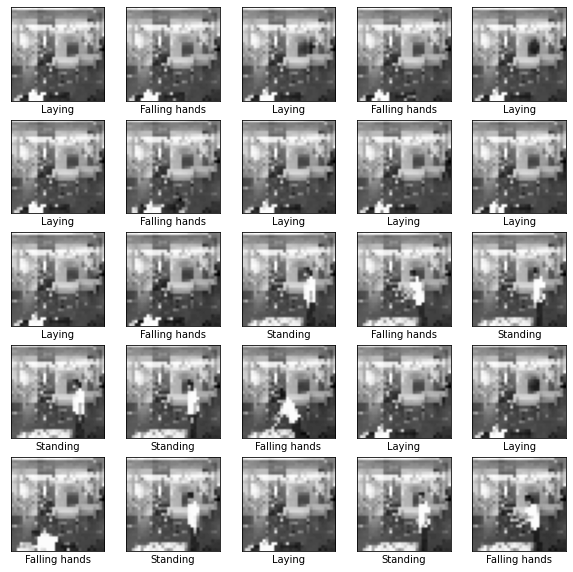

In [ ]:
class_name = [    '?????' ,
                'Falling hands' ,
                 'Falling knees' ,
                 'Falling backwards',
                 'Falling sideward' ,
                ' Falling chair',
                ' Walking',
                 'Standing' ,
                 'Sitting' ,
                 'Picking object' ,
                 'Jumping' ,
                 'Laying' ]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_1[i], cmap = 'gray')
    plt.xlabel(class_name[label_1[i]])
plt.show()

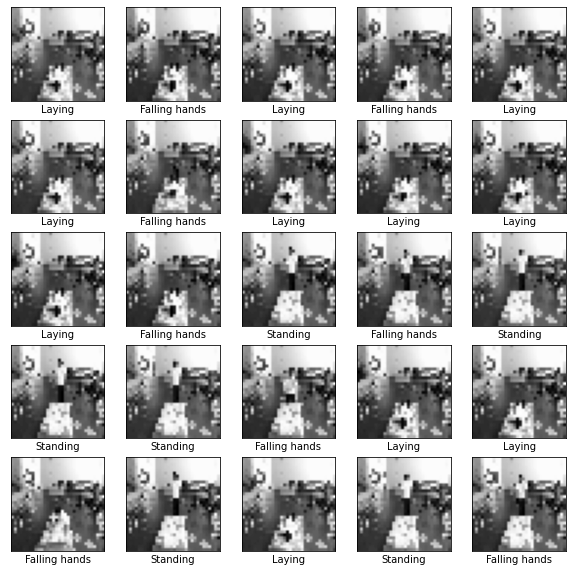

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_2[i], cmap = 'gray')
    plt.xlabel(class_name[label_2[i]])
plt.show()

In [ ]:

data = SUB.loc[name_1].values
print(img_1.shape)
print(img_2.shape)
print(data.shape)


print((label_2 == data[:,-1]).all())
print((label_1 == data[:,-1]).all())

(258113, 32, 32)
(258113, 32, 32)
(258113, 29)
True
True


In [ ]:

# def set_seed(): 
#     SEED = 0 
#     os.environ['PYTHONHASHSEED']=str(SEED)
#     np.random.seed(SEED)
#     tf.random.set_seed(SEED)
#     rn.seed(SEED)
#     session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#     tf.compat.v1.keras.backend.set_session(sess)

# set_seed()
X_csv, y_csv = data[:,:-1] , data[:,-1]

y_csv = np.where(y_csv == 20 , 0, y_csv)
label_1 = np.where(label_1 == 20 , 0, label_1)
label_2 = np.where(label_2 == 20, 0, label_2)
X_train_csv,X_rem_csv,y_train_csv,y_rem_csv = train_test_split(X_csv, y_csv, 
                                                                 train_size = 0.6,
                                                                 random_state = 42)

X_val_csv, X_test_csv, y_val_csv, y_test_csv = train_test_split(X_rem_csv, y_rem_csv, 
                                                                  test_size = 0.5, 
                                                                  random_state = 42)

print('X_train_csv shape : ',X_train_csv.shape)
print('X_test_csv shape : ',X_test_csv.shape)
print('X_val_csv shape : ',X_val_csv.shape)
print('y_train_csv shape : ',y_train_csv.shape)
print('y_test_csv shape : ',y_test_csv.shape)
print('y_val_csv shape : ',y_val_csv.shape)

Y_train_csv = to_categorical(y_train_csv, 12)
Y_test_csv = to_categorical(y_test_csv, 12)
Y_val_csv = to_categorical(y_val_csv, 12)

print('Y_train_csv shape : ',Y_train_csv.shape)
print('Y_test_csv shape : ',Y_test_csv.shape)
print('Y_val_csv shape : ',Y_val_csv.shape)



X_train_1,X_rem_1,y_train_1,y_rem_1 = train_test_split(img_1,label_1,
                                                         train_size = 0.6,
                                                         random_state = 42,
                                                         )

X_val_1,X_test_1,y_val_1,y_test_1 = train_test_split(X_rem_1,y_rem_1,
                                                         test_size = 0.5,
                                                         random_state = 42,
                                                         )
print('*'*20)
print('X_train_1 shape : ',X_train_1.shape)
print('X_test_1 shape : ',X_test_1.shape)
print('X_val_1 shape : ',X_val_1.shape)
print('y_train_1 shape : ',y_train_1.shape)
print('y_test_1 shape : ',y_test_1.shape)
print('y_val_1 shape : ',y_val_1.shape)


Y_train_1 = to_categorical(y_train_1, 12)
Y_test_1 = to_categorical(y_test_1, 12)
Y_val_1 = to_categorical(y_val_1, 12)

print('Y_train_1 shape : ',Y_train_1.shape)
print('Y_test_1 shape : ',Y_test_1.shape)
print('Y_val_1 shape : ',Y_val_1.shape)



X_train_2,X_rem_2,y_train_2,y_rem_2 = train_test_split(img_2,label_2,
                                                         train_size = 0.6,
                                                         random_state = 42,
                                                         )

X_val_2,X_test_2,y_val_2,y_test_2 = train_test_split(X_rem_2,y_rem_2,
                                                         test_size = 0.5,
                                                         random_state = 42,
                                                         )

print('*'*20)
print('X_train_2 shape : ',X_train_2.shape)
print('X_test_2 shape : ',X_test_2.shape)
print('X_val_2 shape : ',X_val_2.shape)
print('y_train_2 shape : ',y_train_2.shape)
print('y_test_2 shape : ',y_test_2.shape)
print('y_val_2 shape : ',y_val_2.shape)


Y_train_2 = to_categorical(y_train_2, 12)
Y_test_2 = to_categorical(y_test_2, 12)
Y_val_2 = to_categorical(y_val_2, 12)

print('Y_train_2 shape : ',Y_train_2.shape)
print('Y_test_2 shape : ',Y_test_2.shape)
print('Y_val_2 shape : ',Y_val_2.shape)


X_train_csv shape :  (154867, 28)
X_test_csv shape :  (51623, 28)
X_val_csv shape :  (51623, 28)
y_train_csv shape :  (154867,)
y_test_csv shape :  (51623,)
y_val_csv shape :  (51623,)
Y_train_csv shape :  (154867, 12)
Y_test_csv shape :  (51623, 12)
Y_val_csv shape :  (51623, 12)
********************
X_train_1 shape :  (154867, 32, 32)
X_test_1 shape :  (51623, 32, 32)
X_val_1 shape :  (51623, 32, 32)
y_train_1 shape :  (154867,)
y_test_1 shape :  (51623,)
y_val_1 shape :  (51623,)
Y_train_1 shape :  (154867, 12)
Y_test_1 shape :  (51623, 12)
Y_val_1 shape :  (51623, 12)
********************
X_train_2 shape :  (154867, 32, 32)
X_test_2 shape :  (51623, 32, 32)
X_val_2 shape :  (51623, 32, 32)
y_train_2 shape :  (154867,)
y_test_2 shape :  (51623,)
y_val_2 shape :  (51623,)
Y_train_2 shape :  (154867, 12)
Y_test_2 shape :  (51623, 12)
Y_val_2 shape :  (51623, 12)


In [ ]:
def convert_to_categorical (y_train, y_test, y_val) :
    print('--------------------------To Categorical ---------------------------')
    Y_train = to_categorical(y_train, 12)
    Y_test = to_categorical(y_test, 12)
    Y_val = to_categorical(y_val,12)
    
    print('Before    : ', y_train[0])
    print('After     : ',Y_train[0])
    return Y_train, Y_test, Y_val 

Y_train_1 , Y_test_1 , Y_val_1 = convert_to_categorical (y_train_1, y_test_1, y_val_1)
Y_train_2 , Y_test_2 , Y_val_2 = convert_to_categorical (y_train_2, y_test_2, y_val_2)

--------------------------To Categorical ---------------------------
Before    :  6
After     :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
--------------------------To Categorical ---------------------------
Before    :  6
After     :  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [ ]:
print((y_train_1 == y_train_csv).all())
print((y_train_2 == y_train_csv).all())

print((y_val_1 == y_val_csv).all())
print((y_val_2 == y_val_csv).all())

print((y_test_1 == y_test_csv).all())
print((y_test_2 == y_test_csv).all())

True
True
True
True
True
True


In [ ]:

def display_result(y_test , y_pred) :
    print('Accuracy score : ', accuracy_score(y_test , y_pred) )
    print('Precision score : ', precision_score(y_test , y_pred, average='weighted'))
    print('Recall score : ', recall_score(y_test , y_pred, average='weighted'))
    print('F1 score : ', f1_score(y_test , y_pred, average='weighted'))
    
def display_result123(y_test , y_pred) :
    print('Accuracy score : ', accuracy_score(y_test , y_pred) )
    print('Precision score : ', precision_score(y_test , y_pred, average='macro'))
    print('Recall score : ', recall_score(y_test , y_pred, average='macro'))
    print('F1 score : ', f1_score(y_test , y_pred, average='macro'))
    
def scaled_data(X_train, X_test, X_val):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    return X_train_scaled, X_test_scaled , X_val_scaled


def convert_to_categorical (y_train, y_test, y_val) :
    print('--------------------------To Categorical ---------------------------')
    Y_train = to_categorical(y_train, 12)
    Y_test = to_categorical(y_test, 12)
    Y_val = to_categorical(y_val,12)
    
    print('Before    : ', y_train[0])
    print('After     : ',Y_train[0])
    return Y_train, Y_test, Y_val 


# X_train_csv_scaled, X_test_csv_scaled , X_val_csv_scaled = scaled_data(X_train_csv, X_test_csv, X_val_csv)
# Y_train_csv , Y_test_csv , Y_val_csv = convert_to_categorical (y_train_csv, y_test_csv, y_val_csv)


In [ ]:
X_train_1_scaled = X_train_1/255.0
X_train_2_scaled = X_train_2/255.0

X_val_1_scaled = X_val_1/255.0
X_val_2_scaled = X_val_2/255.0

X_test_1_scaled = X_test_1/255.0
X_test_2_scaled = X_test_2/255.0

In [ ]:
X_train_1_scaled.shape

(154867, 32, 32)

In [ ]:
# X_train_1_scaled = X_train_1_scaled.reshape(X_train_1_scaled.shape[0],32,32)
# X_test_1_scaled = X_test_1_scaled.reshape(X_test_1_scaled.shape[0],32,32)
# X_val_1_scaled = X_val_1_scaled.reshape(X_val_1_scaled.shape[0],32,32)

# X_train_2_scaled = X_train_2_scaled.reshape(X_train_2_scaled.shape[0],32,32)
# X_test_2_scaled = X_test_2_scaled.reshape(X_test_2_scaled.shape[0],32,32)
# X_val_2_scaled = X_val_2_scaled.reshape(X_val_2_scaled.shape[0],32,32)

In [ ]:
print(X_train_1_scaled.shape)
print(X_test_1_scaled.shape)
print(X_val_1_scaled.shape)

print(X_train_2_scaled.shape)
print(X_test_2_scaled.shape)
print(X_val_2_scaled.shape)

(154867, 32, 32)
(51623, 32, 32)
(51623, 32, 32)
(154867, 32, 32)
(51623, 32, 32)
(51623, 32, 32)


# IMG1 

### Each Experts 

#### Expert 1

In [ ]:
expert_1 = model_Expert( 32, 32, num_seed = 0,
                        num_filters = [32])

expert_1.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )



# f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/expert_1.hdf5", 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')
# history_1 = expert_1.fit(x = X_train_1_scaled , 
#                       y=  Y_train_1,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_1_scaled , Y_val_1),
#                       callbacks = [f1_callback_concat]
#                      )


print("best model: ")
expert_1.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/expert_1.hdf5")
print(expert_1.evaluate(X_val_1_scaled , Y_val_1))
print(expert_1.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(expert_1.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(expert_1.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)

best model: 
1614/1614 [==============================] - 17s 4ms/step - loss: 0.0209 - categorical_accuracy: 0.9946 - precision: 0.9947 - recall: 0.9944 - f1_score: 0.9945
[0.020932843908667564, 0.9945760369300842, 0.9946906566619873, 0.9943823218345642, 0.9945120811462402]
1614/1614 [==============================] - 6s 4ms/step - loss: 0.0226 - categorical_accuracy: 0.9941 - precision: 0.9942 - recall: 0.9939 - f1_score: 0.9940
[0.022636467590928078, 0.994091808795929, 0.9942448735237122, 0.9939174652099609, 0.9940285682678223]
Accuracy score :  0.9945760610580555
Precision score :  0.9945262143910366
Recall score :  0.9945760610580555
F1 score :  0.9945120600963859
********************
Accuracy score :  0.9940917807953819
Precision score :  0.99406358878414
Recall score :  0.9940917807953819
F1 score :  0.99402857679012


#### Expert 2

In [ ]:
expert_2 = model_Expert( 32, 32, num_seed = 1,
                        num_filters = [32])
expert_2.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )



# f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/expert_2.hdf5", 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')
# history_1 = expert_2.fit(x = X_train_1_scaled , 
#                       y=  Y_train_1,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_1_scaled , Y_val_1),
#                       callbacks = [f1_callback_concat]
#                      )


print("best model: ")
expert_2.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/expert_2.hdf5")
print(expert_2.evaluate(X_val_1_scaled , Y_val_1))
print(expert_2.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(expert_2.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(expert_2.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)

best model: 
1614/1614 [==============================] - 6s 4ms/step - loss: 0.0216 - categorical_accuracy: 0.9944 - precision: 0.9947 - recall: 0.9943 - f1_score: 0.9944
[0.021623650565743446, 0.9944404363632202, 0.9946711659431458, 0.9943435788154602, 0.9943598508834839]
1614/1614 [==============================] - 6s 4ms/step - loss: 0.0219 - categorical_accuracy: 0.9942 - precision: 0.9944 - recall: 0.9941 - f1_score: 0.9941
[0.02185520902276039, 0.9942273497581482, 0.9943613409996033, 0.994072437286377, 0.9941370487213135]
Accuracy score :  0.9944404625845069
Precision score :  0.9943435158360044
Recall score :  0.9944404625845069
F1 score :  0.9943599278386615
********************
Accuracy score :  0.9942273792689306
Precision score :  0.9941205496740986
Recall score :  0.9942273792689306
F1 score :  0.9941370530234571


#### Expert 3

In [ ]:
expert_3 = model_Expert( 32, 32, num_seed = 2,
                        num_filters = [32])
expert_3.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )



# f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/expert_3.hdf5", 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')
# history_1 = expert_3.fit(x = X_train_1_scaled , 
#                       y=  Y_train_1,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_1_scaled , Y_val_1),
#                       callbacks = [f1_callback_concat]
#                      )


print("best model: ")
expert_3.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/expert_3.hdf5")
print(expert_3.evaluate(X_val_1_scaled , Y_val_1))
print(expert_3.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(expert_3.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(expert_3.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)

best model: 
1614/1614 [==============================] - 6s 4ms/step - loss: 0.0199 - categorical_accuracy: 0.9947 - precision: 0.9951 - recall: 0.9945 - f1_score: 0.9947
[0.01992051675915718, 0.9947310090065002, 0.995134711265564, 0.9944985508918762, 0.9946647882461548]
1614/1614 [==============================] - 6s 4ms/step - loss: 0.0193 - categorical_accuracy: 0.9941 - precision: 0.9943 - recall: 0.9941 - f1_score: 0.9940
[0.019251372665166855, 0.994149923324585, 0.9943035244941711, 0.994072437286377, 0.9940469264984131]
Accuracy score :  0.9947310307421111
Precision score :  0.9946361627648627
Recall score :  0.9947310307421111
F1 score :  0.9946647835603992
********************
Accuracy score :  0.9941498944269027
Precision score :  0.9940419201906052
Recall score :  0.9941498944269027
F1 score :  0.9940468542601715


#### Expert 4

In [ ]:
expert_4 = model_Expert( 32, 32, num_seed = 3,
                        num_filters = [32])
expert_4.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )



# f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/expert_4.hdf5", 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')
# history_1 = expert_4.fit(x = X_train_1_scaled , 
#                       y=  Y_train_1,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_1_scaled , Y_val_1),
#                       callbacks = [f1_callback_concat]
#                      )


print("best model: ")
expert_4.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/expert_4.hdf5")
print(expert_4.evaluate(X_val_1_scaled , Y_val_1))
print(expert_4.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(expert_4.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(expert_4.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)

best model: 
1614/1614 [==============================] - 6s 4ms/step - loss: 0.0215 - categorical_accuracy: 0.9943 - precision: 0.9946 - recall: 0.9940 - f1_score: 0.9942
[0.021524609997868538, 0.9942660927772522, 0.9945728778839111, 0.993994951248169, 0.9941763877868652]
1614/1614 [==============================] - 6s 4ms/step - loss: 0.0214 - categorical_accuracy: 0.9940 - precision: 0.9943 - recall: 0.9939 - f1_score: 0.9939
[0.02137942798435688, 0.994033694267273, 0.9942638874053955, 0.9938787221908569, 0.9939499497413635]
Accuracy score :  0.9942661216899444
Precision score :  0.994193457897794
Recall score :  0.9942661216899444
F1 score :  0.9941764173195109
********************
Accuracy score :  0.9940336671638611
Precision score :  0.9939284126865694
Recall score :  0.9940336671638611
F1 score :  0.9939499274721137


#### Expert 5

In [ ]:
expert_5 = model_Expert( 32, 32, num_seed = 4,
                        num_filters = [32])
expert_5.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )



# f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/expert_5.hdf5", 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')
# history_1 = expert_5.fit(x = X_train_1_scaled , 
#                       y=  Y_train_1,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_1_scaled , Y_val_1),
#                       callbacks = [f1_callback_concat]
#                      )


print("best model: ")
expert_5.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/expert_5.hdf5")
print(expert_5.evaluate(X_val_1_scaled , Y_val_1))
print(expert_5.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(expert_5.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(expert_5.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)

best model: 
1614/1614 [==============================] - 6s 4ms/step - loss: 0.0207 - categorical_accuracy: 0.9948 - precision: 0.9950 - recall: 0.9947 - f1_score: 0.9947
[0.02069973759353161, 0.9948472380638123, 0.9949620962142944, 0.9946922659873962, 0.9947456121444702]
1614/1614 [==============================] - 6s 4ms/step - loss: 0.0239 - categorical_accuracy: 0.9936 - precision: 0.9938 - recall: 0.9934 - f1_score: 0.9935
[0.023934300988912582, 0.9935881495475769, 0.993798553943634, 0.9933750629425049, 0.9934515953063965]
Accuracy score :  0.9948472580051527
Precision score :  0.9947352305225445
Recall score :  0.9948472580051527
F1 score :  0.9947456704422479
********************
Accuracy score :  0.9935881293222013
Precision score :  0.9934782644067268
Recall score :  0.9935881293222013
F1 score :  0.9934515692279677


### Combining Experts 

In [ ]:
img1_gating = model_1concat_gating(shape1 = 32,
                                   shape2 = 32, 
                                       all_list_filters = [[32],
                                                           [32],
                                                           [32],
                                                           [32],
                                                           [32]
                                                          ], 
                                       list_num_experts = 5, 
                                       same_seed = False)
img1_gating.summary()

expert concat shape :  (None, 5, 12)
gate mul expert :  (None, 12)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 30, 30, 30)   300         ['input_6[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 30, 30, 32)   320         ['input_6[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 30, 30, 32)   320         ['input_6[0][0]']                
                         

best model: 
1614/1614 [==============================] - 11s 6ms/step - loss: 0.0177 - categorical_accuracy: 0.9948 - precision: 0.9950 - recall: 0.9948 - f1_score: 0.9948
[0.017748933285474777, 0.9948472380638123, 0.9949817657470703, 0.9947697520256042, 0.9947931170463562]
1614/1614 [==============================] - 10s 6ms/step - loss: 0.0190 - categorical_accuracy: 0.9948 - precision: 0.9950 - recall: 0.9946 - f1_score: 0.9947
[0.018962891772389412, 0.9947891235351562, 0.9950195550918579, 0.9946147799491882, 0.9947319030761719]
Accuracy score :  0.9948472580051527
Precision score :  0.9947775525190049
Recall score :  0.9948472580051527
F1 score :  0.9947931191299431
********************
Accuracy score :  0.9947891443736319
Precision score :  0.9947235462183777
Recall score :  0.9947891443736319
F1 score :  0.9947318875750273


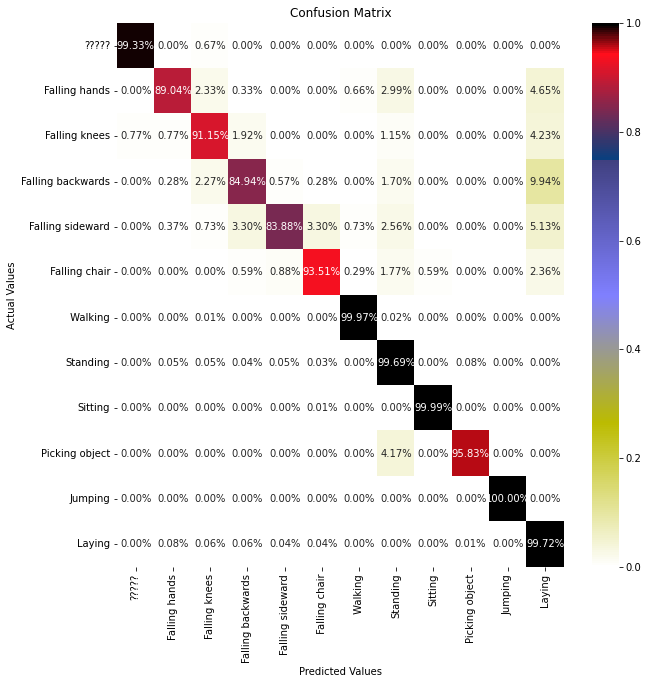

[0.9933, 0.8904, 0.9115, 0.8494, 0.8388, 0.9351, 0.9997, 0.9969, 0.9999, 0.9583, 1.0, 0.9972]


In [ ]:
img1_gating.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )


print("best model: ")
img1_gating.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/raw_img1.hdf5")
print(img1_gating.evaluate(X_val_1_scaled , Y_val_1))
print(img1_gating.evaluate(X_test_1_scaled , Y_test_1))


y_val = np.argmax(img1_gating.predict(X_val_1_scaled ), axis = 1 )
display_result(y_val_1, y_val)

print('*'*20)
y_test = np.argmax(img1_gating.predict(X_test_1_scaled ), axis = 1 )
display_result(y_test_1, y_test)


k = draw_cm(y_test_1,y_test) 
print(k)

In [ ]:

# UNCOMMENT IF U WANT TO TRAIN THE MODEL

# img1_gating.compile(
#                  optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
#                  loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
#                  metrics = [
#                             keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#                             keras.metrics.Precision(name='precision'),
#                             keras.metrics.Recall(name='recall'),
#                             tfa.metrics.F1Score( num_classes=12,   
#                                                 name = 'f1_score',
#                                                 average='weighted')                          
#                            ]
#     )

# f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/raw_img1.hdf5", 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')
# history_1 = img1_gating.fit(x = X_train_1_scaled , 
#                       y=  Y_train_1,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_1_scaled , Y_val_1),
#                       callbacks = [f1_callback_concat]
#                      )


# print("best model: ")
# img1_gating.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_1/raw_img1.hdf5")
# print(img1_gating.evaluate(X_val_1_scaled , Y_val_1))
# print(img1_gating.evaluate(X_test_1_scaled , Y_test_1))


# y_val = np.argmax(img1_gating.predict(X_val_1_scaled ), axis = 1 )
# display_result(y_val_1, y_val)

# print('*'*20)
# y_test = np.argmax(img1_gating.predict(X_test_1_scaled ), axis = 1 )
# display_result(y_test_1, y_test)





# IMG2

### Each Experts 

##### Expert 1

In [ ]:
expert_1 = model_Expert( 32, 32, num_seed = 0,
                        num_filters = [32])
expert_1.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )



f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_1.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')
history_1 = expert_1.fit(x = X_train_2_scaled , 
                      y=  Y_train_2,           
                      epochs= 30, 
                      batch_size = 2**10 , 
                      validation_data = (X_val_2_scaled , Y_val_2),
                      callbacks = [f1_callback_concat]
                     )


print("best model: ")
expert_1.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_1.hdf5")
print(expert_1.evaluate(X_val_2_scaled , Y_val_2))
print(expert_1.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(expert_1.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(expert_1.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.1389 - categorical_accuracy: 0.9620 - precision: 0.9745 - recall: 0.9551 - f1_score: 0.9605
Epoch 1: val_f1_score improved from -inf to 0.05736, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_1.hdf5
152/152 [==============================] - 9s 44ms/step - loss: 0.1389 - categorical_accuracy: 0.9620 - precision: 0.9745 - recall: 0.9551 - f1_score: 0.9605 - val_loss: 4.9133 - val_categorical_accuracy: 0.1843 - val_precision: 0.1843 - val_recall: 0.1843 - val_f1_score: 0.0574
Epoch 2/30
151/152 [============================>.] - ETA: 0s - loss: 0.0505 - categorical_accuracy: 0.9845 - precision: 0.9866 - recall: 0.9825 - f1_score: 0.9840
Epoch 2: val_f1_score did not improve from 0.05736
152/152 [==============================] - 5s 33ms/step - loss: 0.0505 - categorical_accuracy: 0.9845 - precision: 0.9866 - recall: 0.9825 - f1_score: 0.9840 - val_loss: 8.2193 - val

#### Expert 2 

In [ ]:
expert_2 = model_Expert( 32, 32, num_seed = 0,
                        num_filters = [32,28])
expert_2.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )




f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_2.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')
history_1 = expert_2.fit(x = X_train_2_scaled , 
                      y=  Y_train_2,           
                      epochs= 30, 
                      batch_size = 2**10 , 
                      validation_data = (X_val_2_scaled , Y_val_2),
                      callbacks = [f1_callback_concat]
                     )


print("best model: ")
expert_2.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_2.hdf5")
print(expert_2.evaluate(X_val_2_scaled , Y_val_2))
print(expert_2.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(expert_2.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(expert_2.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.1506 - categorical_accuracy: 0.9600 - precision: 0.9760 - recall: 0.9506 - f1_score: 0.9575
Epoch 1: val_f1_score improved from -inf to 0.01755, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_2.hdf5
152/152 [==============================] - 8s 43ms/step - loss: 0.1506 - categorical_accuracy: 0.9600 - precision: 0.9760 - recall: 0.9506 - f1_score: 0.9575 - val_loss: 3.6834 - val_categorical_accuracy: 0.0174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0175
Epoch 2/30
151/152 [============================>.] - ETA: 0s - loss: 0.0444 - categorical_accuracy: 0.9859 - precision: 0.9882 - recall: 0.9835 - f1_score: 0.9854
Epoch 2: val_f1_score improved from 0.01755 to 0.02613, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_2.hdf5
152/152 [==============================] - 5s 31ms/step - loss:

#### Expert 3

In [ ]:
expert_3 = model_Expert( 32, 32, num_seed = 0,
                        num_filters = [32,28,24])
expert_3.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )



f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_3.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')
history_1 = expert_3.fit(x = X_train_2_scaled , 
                      y=  Y_train_2,           
                      epochs= 30, 
                      batch_size = 2**10 , 
                      validation_data = (X_val_2_scaled , Y_val_2),
                      callbacks = [f1_callback_concat]
                     )


print("best model: ")
expert_3.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_3.hdf5")
print(expert_3.evaluate(X_val_2_scaled , Y_val_2))
print(expert_3.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(expert_3.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(expert_3.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)

Epoch 1/30
149/152 [============================>.] - ETA: 0s - loss: 0.2103 - categorical_accuracy: 0.9445 - precision: 0.9681 - recall: 0.9312 - f1_score: 0.9408
Epoch 1: val_f1_score improved from -inf to 0.00007, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_3.hdf5
152/152 [==============================] - 6s 30ms/step - loss: 0.2085 - categorical_accuracy: 0.9449 - precision: 0.9683 - recall: 0.9318 - f1_score: 0.9413 - val_loss: 2.7668 - val_categorical_accuracy: 0.0058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 6.7243e-05
Epoch 2/30
151/152 [============================>.] - ETA: 0s - loss: 0.0590 - categorical_accuracy: 0.9821 - precision: 0.9866 - recall: 0.9781 - f1_score: 0.9809
Epoch 2: val_f1_score improved from 0.00007 to 0.13605, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_3.hdf5
152/152 [==============================] - 3s 19ms/step - l

#### Expert 4

In [ ]:
expert_4 = model_Expert( 32, 32, num_seed = 0,
                        num_filters = [32,28,24,24])
expert_4.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )



f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_4.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')
history_1 = expert_4.fit(x = X_train_2_scaled , 
                      y=  Y_train_2,           
                      epochs= 30, 
                      batch_size = 2**10 , 
                      validation_data = (X_val_2_scaled , Y_val_2),
                      callbacks = [f1_callback_concat]
                     )


print("best model: ")
expert_4.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_4.hdf5")
print(expert_4.evaluate(X_val_2_scaled , Y_val_2))
print(expert_4.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(expert_4.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(expert_4.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)

Epoch 1/30
151/152 [============================>.] - ETA: 0s - loss: 0.3025 - categorical_accuracy: 0.9183 - precision: 0.9484 - recall: 0.9001 - f1_score: 0.9116
Epoch 1: val_f1_score improved from -inf to 0.00014, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_4.hdf5
152/152 [==============================] - 7s 40ms/step - loss: 0.3024 - categorical_accuracy: 0.9183 - precision: 0.9484 - recall: 0.9002 - f1_score: 0.9116 - val_loss: 2.6303 - val_categorical_accuracy: 0.0062 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 1.4455e-04
Epoch 2/30
151/152 [============================>.] - ETA: 0s - loss: 0.1106 - categorical_accuracy: 0.9676 - precision: 0.9782 - recall: 0.9607 - f1_score: 0.9633
Epoch 2: val_f1_score improved from 0.00014 to 0.07907, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_4.hdf5
152/152 [==============================] - 5s 31ms/step - l

#### Expert 5

In [ ]:
expert_5 = model_Expert( 32, 32, num_seed = 0,
                        num_filters = [32,28,24,24,20])
expert_5.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )



f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_5.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')
history_1 = expert_5.fit(x = X_train_2_scaled , 
                      y=  Y_train_2,           
                      epochs= 30, 
                      batch_size = 2**10 , 
                      validation_data = (X_val_2_scaled , Y_val_2),
                      callbacks = [f1_callback_concat]
                     )


print("best model: ")
expert_5.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_5.hdf5")
print(expert_5.evaluate(X_val_2_scaled , Y_val_2))
print(expert_5.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(expert_5.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(expert_5.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.1164 - categorical_accuracy: 0.9679 - precision: 0.9798 - recall: 0.9617 - f1_score: 0.9670
Epoch 1: val_f1_score improved from -inf to 0.14190, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_5.hdf5
152/152 [==============================] - 24s 74ms/step - loss: 0.1164 - categorical_accuracy: 0.9679 - precision: 0.9798 - recall: 0.9617 - f1_score: 0.9670 - val_loss: 2.9265 - val_categorical_accuracy: 0.2488 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.1419
Epoch 2/30
151/152 [============================>.] - ETA: 0s - loss: 0.0292 - categorical_accuracy: 0.9909 - precision: 0.9916 - recall: 0.9899 - f1_score: 0.9907
Epoch 2: val_f1_score improved from 0.14190 to 0.21860, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_5.hdf5
152/152 [==============================] - 5s 35ms/step - loss

#### Expert 6

In [ ]:
expert_6 = model_Expert( 32, 32, num_seed = 0,
                        num_filters = [32,28,24,24,20,20])
expert_6.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )



f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_6.hdf5", 
                              monitor='val_f1_score', 
                              verbose=1, 
                              save_best_only=True,
                              mode='max')
history_1 = expert_6.fit(x = X_train_2_scaled , 
                      y=  Y_train_2,           
                      epochs= 30, 
                      batch_size = 2**10 , 
                      validation_data = (X_val_2_scaled , Y_val_2),
                      callbacks = [f1_callback_concat]
                     )


print("best model: ")
expert_6.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_6.hdf5")
print(expert_6.evaluate(X_val_2_scaled , Y_val_2))
print(expert_6.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(expert_6.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(expert_6.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)

Epoch 1/30
152/152 [==============================] - ETA: 0s - loss: 0.1144 - categorical_accuracy: 0.9686 - precision: 0.9804 - recall: 0.9625 - f1_score: 0.9678
Epoch 1: val_f1_score improved from -inf to 0.07910, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_6.hdf5
152/152 [==============================] - 27s 75ms/step - loss: 0.1144 - categorical_accuracy: 0.9686 - precision: 0.9804 - recall: 0.9625 - f1_score: 0.9678 - val_loss: 2.9805 - val_categorical_accuracy: 0.2196 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0791
Epoch 2/30
151/152 [============================>.] - ETA: 0s - loss: 0.0268 - categorical_accuracy: 0.9916 - precision: 0.9923 - recall: 0.9908 - f1_score: 0.9915
Epoch 2: val_f1_score improved from 0.07910 to 0.12322, saving model to /content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/expert_6.hdf5
152/152 [==============================] - 9s 57ms/step - loss

### Combining Experts 

expert concat shape :  (None, 6, 12)
gate mul expert :  (None, 12)
best model: 
1614/1614 [==============================] - 14s 8ms/step - loss: 0.0157 - categorical_accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - f1_score: 0.9961
[0.01565481908619404, 0.9962032437324524, 0.9962031245231628, 0.9961645007133484, 0.9961472749710083]
1614/1614 [==============================] - 14s 9ms/step - loss: 0.0163 - categorical_accuracy: 0.9959 - precision: 0.9960 - recall: 0.9959 - f1_score: 0.9959
[0.016296153888106346, 0.9959320425987244, 0.9959704875946045, 0.9958932995796204, 0.9958875179290771]
Accuracy score :  0.9962032427406389
Precision score :  0.9961613628869281
Recall score :  0.9962032427406389
F1 score :  0.9961472217330571
********************
Accuracy score :  0.9959320457935417
Precision score :  0.9958859629193424
Recall score :  0.9959320457935417
F1 score :  0.9958875323577623


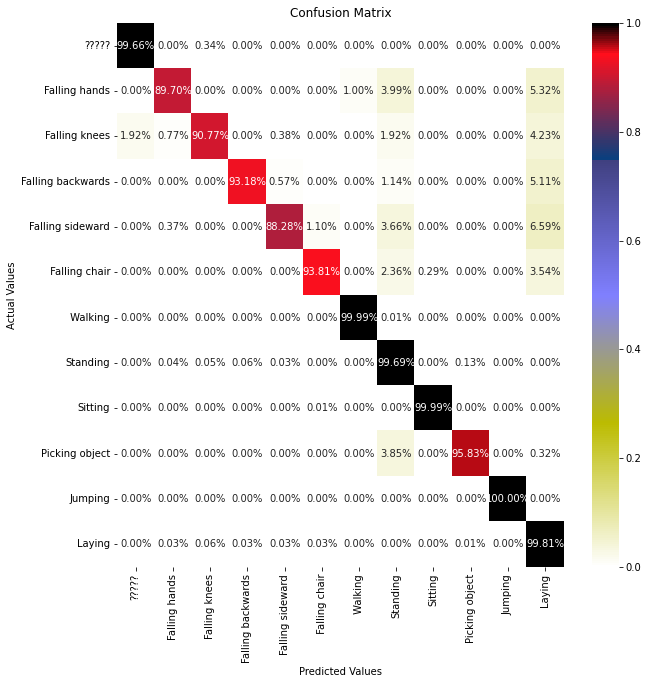

[0.9966, 0.897, 0.9077, 0.9318, 0.8828, 0.9381, 0.9999, 0.9969, 0.9999, 0.9583, 1.0, 0.9981]


In [ ]:
# LOAD OUR PRE-TRAINED WEIGHT 
 

img2_gating = model_1concat_gating(shape1 = 32,
                                       shape2 = 32, 
                                       all_list_filters = [[32],[32,28],[32,28,24],[32,28,24,24],
                                                           [32,28,24,24,20],
                                                           [32,28,24,24,20,20]
                                                          ], 
                                       list_num_experts = 6, 
                                       same_seed = True)


img2_gating.compile(
                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted')                          
                           ]
    )


print("best model: ")
img2_gating.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/Raw_model /img_2/raw_img2.hdf5")

print(img2_gating.evaluate(X_val_2_scaled , Y_val_2))
print(img2_gating.evaluate(X_test_2_scaled , Y_test_2))


y_val = np.argmax(img2_gating.predict(X_val_2_scaled ), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(img2_gating.predict(X_test_2_scaled ), axis = 1 )
display_result(y_test_2, y_test)


k = draw_cm(y_test_2,y_test) 
print(k)


In [ ]:
# UNCOMMENT IF U WANT TO TRAIN THE MODEL



# img2_gating = model_1concat_gating(shape1 = 32,
#                                     shape2 = 32, 
#                                        all_list_filters = [[32],
#                                                            [32,28],
#                                                            [32,28,24],
#                                                            [32,28,24,24],
#                                                            [32,28,24,24,20],
#                                                            [32,28,24,24,20,20]
#                                                           ], 
#                                        list_num_experts = 6, 
#                                        same_seed = False )

# img2_gating.compile(
#                  optimizer = tf.keras.optimizers.Adadelta(learning_rate=1, rho=0.95, epsilon=1e-08, decay=0.0),
#                  loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
#                  metrics = [
#                             keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#                             keras.metrics.Precision(name='precision'),
#                             keras.metrics.Recall(name='recall'),
#                             tfa.metrics.F1Score( num_classes=12,   
#                                                 name = 'f1_score',
#                                                 average='weighted')                          
#                            ]
#     )

# f1_callback_concat = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/raw_img2x.hdf5", 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')
# history_2 = img2_gating.fit(x = X_train_2_scaled , 
#                       y=  Y_train_2,           
#                       epochs= 30, 
#                       batch_size = 2**10 , 
#                       validation_data = (X_val_2_scaled , Y_val_2),
#                       callbacks = [f1_callback_concat]
#                      )



# print("best model: ")
# img2_gating.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/raw_img2x.hdf5")
# print(img2_gating.evaluate(X_val_2_scaled , Y_val_2))
# print(img2_gating.evaluate(X_test_2_scaled , Y_test_2))


# y_val = np.argmax(img2_gating.predict(X_val_2_scaled ), axis = 1 )
# display_result(y_val_2, y_val)

# print('*'*20)
# y_test = np.argmax(img2_gating.predict(X_test_2_scaled ), axis = 1 )
# display_result(y_test_2, y_test)

# IMAGE 1 + IMAGE 2 

## Concat

expert concat shape :  (None, 5, 12)
gate mul expert :  (None, 12)
expert concat shape :  (None, 6, 12)
gate mul expert :  (None, 12)
best model: 
1614/1614 [==============================] - 60s 28ms/step - loss: 0.0156 - categorical_accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - f1_score: 0.9965
[0.015569208189845085, 0.9964938163757324, 0.9965130686759949, 0.9964744448661804, 0.9964787364006042]
1614/1614 [==============================] - 46s 28ms/step - loss: 0.0161 - categorical_accuracy: 0.9962 - precision: 0.9962 - recall: 0.9962 - f1_score: 0.9962
[0.016139056533575058, 0.9962032437324524, 0.9962224960327148, 0.9961838722229004, 0.9961940050125122]
Accuracy score :  0.9964938108982431
Precision score :  0.9964739362199961
Recall score :  0.9964938108982431
F1 score :  0.9964787431539388
********************
Accuracy score :  0.9962032427406389
Precision score :  0.9962136745225161
Recall score :  0.9962032427406389
F1 score :  0.9961939925993458


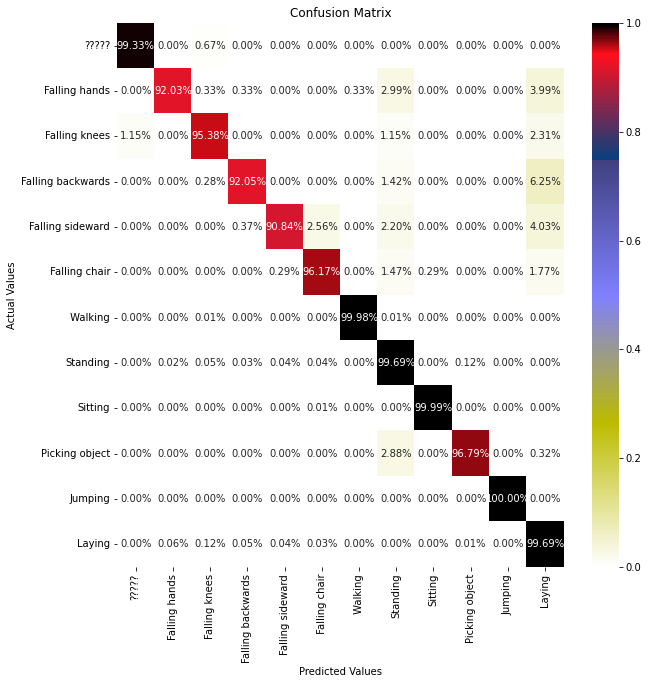

[0.9933, 0.9203, 0.9538, 0.9205, 0.9084, 0.9617, 0.9998, 0.9969, 0.9999, 0.9679, 1.0, 0.9969]


In [ ]:
ss = 'concat'

model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
                           all_list_filters_0 = [[32], [32],[32],[32],[32]], 
                           all_list_filters_1 =  [[32],
                                                  [32,28],
                                                  [32,28,24],
                                                  [32,28,24,24],
                                                  [32,28,24,24,20],
                                                  [32,28,24,24,20,20]], 
                           list_num_experts_0 = 5, 
                           list_num_experts_1 = 6, 
                           same_seed = [False,True],
                           method = ss)
# model_concat_12.summary()


# LOAD OUR PRE-TRAINED WEIGHT 

model_concat_12.compile(

                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.95, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted') 
                 ])




print("best model: ")
path  = "/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/raw_" + ss  + '.hdf5'
model_concat_12.load_weights(path)
print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
display_result(y_test_2, y_test)
dd = draw_cm(y_test_2,y_test)
print(dd)

In [ ]:

# UNCOMMENT IF U WANT TO TRAIN THE MODEL

# model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
#                            all_list_filters_0 = [[32], [32],[32],[32],[32]], 
#                            all_list_filters_1 =  [[32],
#                                                   [32,28],
#                                                   [32,28,24],
#                                                   [32,28,24,24],
#                                                   [32,28,24,24,20],
#                                                   [32,28,24,24,20,20]], 
#                            list_num_experts_0 = 5, 
#                            list_num_experts_1 = 6, 
#                            same_seed = [False,True],
#                            method = 'concat')
# model_concat_12.summary()


# model_concat_12.compile(

#                  optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.95, rho=0.95, epsilon=1e-08, decay=0.0),
#                  loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
#                  metrics = [
#                             keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#                             keras.metrics.Precision(name='precision'),
#                             keras.metrics.Recall(name='recall'),
#                             tfa.metrics.F1Score( num_classes=12,   
#                                                 name = 'f1_score',
#                                                 average='weighted') 
#                  ])

# filepath = 'Saved Model/New_1/gating_img12_3_a_1.hdf5'
# f1_callback1 = ModelCheckpoint(filepath, 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')


# print("best model: ")
# model_concat_12.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/raw_concat.hdf5")
# print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
# print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


# y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
# display_result(y_val_2, y_val)

# print('*'*20)
# y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
# display_result(y_test_2, y_test)

expert concat shape :  (None, 5, 12)
gate mul expert :  (None, 12)
expert concat shape :  (None, 6, 12)
gate mul expert :  (None, 12)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_49 (Conv2D)             (None, 30, 30, 32)   320         ['input_4[0][0]']                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 30, 30, 32)   320         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_36 (MaxPooling2D  (None, 15, 15, 32)  0   

In [ ]:
list(f1_score(y_test_2, y_test, average=None))

[0.9916247906197654,
 0.9421768707482994,
 0.9253731343283582,
 0.941860465116279,
 0.9305816135084427,
 0.9546120058565155,
 0.999843595224441,
 0.9967907855981009,
 0.9998944702406078,
 0.9602543720190779,
 1.0,
 0.9964563646470261]

## Max

expert concat shape :  (None, 5, 12)
gate mul expert :  (None, 12)
expert concat shape :  (None, 6, 12)
gate mul expert :  (None, 12)
best model: 
1614/1614 [==============================] - 62s 31ms/step - loss: 0.0127 - categorical_accuracy: 0.9966 - precision: 0.9967 - recall: 0.9966 - f1_score: 0.9966
[0.01268259808421135, 0.9966487884521484, 0.9967453479766846, 0.9966487884521484, 0.9966309070587158]
1614/1614 [==============================] - 54s 33ms/step - loss: 0.0131 - categorical_accuracy: 0.9964 - precision: 0.9965 - recall: 0.9964 - f1_score: 0.9964
[0.013146981596946716, 0.9964357018470764, 0.996512770652771, 0.9963969588279724, 0.9964200258255005]
Accuracy score :  0.9966487805822986
Precision score :  0.9966311650887328
Recall score :  0.9966487805822986
F1 score :  0.996630933546481
********************
Accuracy score :  0.9964356972667222
Precision score :  0.9964152816828907
Recall score :  0.9964356972667222
F1 score :  0.9964199978823673


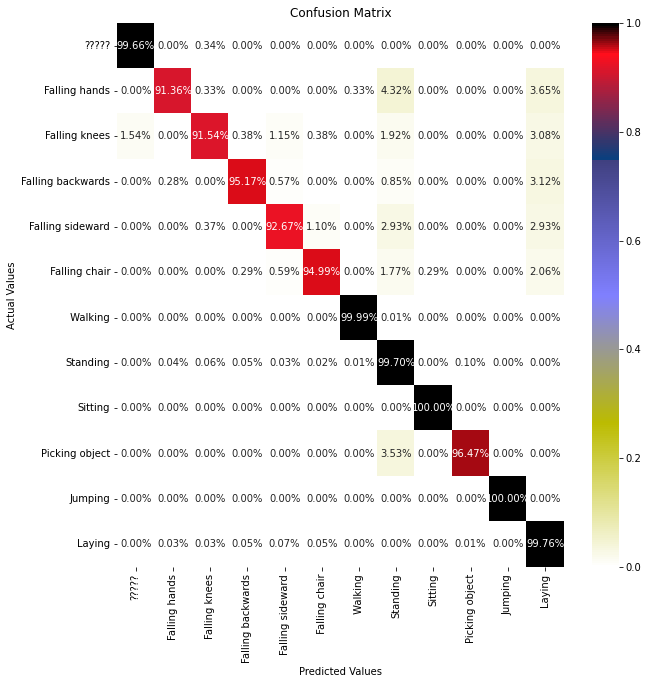

[0.9966, 0.9136, 0.9154, 0.9517, 0.9267, 0.9499, 0.9999, 0.997, 1.0, 0.9647, 1.0, 0.9976]


In [ ]:
ss = 'max'

model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
                           all_list_filters_0 = [[32], [32],[32],[32],[32]], 
                           all_list_filters_1 =  [[32],
                                                  [32,28],
                                                  [32,28,24],
                                                  [32,28,24,24],
                                                  [32,28,24,24,20],
                                                  [32,28,24,24,20,20]], 
                           list_num_experts_0 = 5, 
                           list_num_experts_1 = 6, 
                           same_seed = [False,True],
                           method = ss)


# LOAD OUR PRE-TRAINED WEIGHT 

model_concat_12.compile(

                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted') 
                 ])


print("best model: ")
path  = "/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/raw_" + ss  + '.hdf5'
model_concat_12.load_weights(path)
print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
display_result(y_test_2, y_test)
dd = draw_cm(y_test_2,y_test)
print(dd)

In [ ]:

# UNCOMMENT IF U WANT TO TRAIN THE MODEL

# model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
#                            all_list_filters_0 = [[32], [32],[32],[32],[32]], 
#                            all_list_filters_1 =  [[32],
#                                                   [32,28],
#                                                   [32,28,24],
#                                                   [32,28,24,24],
#                                                   [32,28,24,24,20],
#                                                   [32,28,24,24,20,20]], 
#                            list_num_experts_0 = 5, 
#                            list_num_experts_1 = 6, 
#                            same_seed = [False,True],
#                            method = 'max')
# model_concat_12.summary()


# model_concat_12.compile(

#                  optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.95, rho=0.95, epsilon=1e-08, decay=0.0),
#                  loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
#                  metrics = [
#                             keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#                             keras.metrics.Precision(name='precision'),
#                             keras.metrics.Recall(name='recall'),
#                             tfa.metrics.F1Score( num_classes=12,   
#                                                 name = 'f1_score',
#                                                 average='weighted') 
#                  ])

# filepath = 'Saved Model/New_1/gating_img12_3_a_1.hdf5'
# f1_callback1 = ModelCheckpoint(filepath, 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')


# print("best model: ")
# model_concat_12.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/raw_max.hdf5")
# print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
# print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


# y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
# display_result(y_val_2, y_val)

# print('*'*20)
# y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
# display_result(y_test_2, y_test)

expert concat shape :  (None, 5, 12)
gate mul expert :  (None, 12)
expert concat shape :  (None, 6, 12)
gate mul expert :  (None, 12)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_49 (Conv2D)             (None, 30, 30, 32)   320         ['input_4[0][0]']                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 30, 30, 32)   320         ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_36 (MaxPooling2D  (None, 15, 15, 32)  0   

In [ ]:
list(f1_score(y_test_2, y_test, average=None))

[0.991652754590985,
 0.9385665529010239,
 0.9278752436647173,
 0.9544159544159543,
 0.9267399267399268,
 0.9554896142433235,
 0.9998436115310432,
 0.9964406556224459,
 0.9999472379042895,
 0.9632,
 1.0,
 0.9972202918693537]

## Average

expert concat shape :  (None, 5, 12)
gate mul expert :  (None, 12)
expert concat shape :  (None, 6, 12)
gate mul expert :  (None, 12)
best model: 
1614/1614 [==============================] - 45s 26ms/step - loss: 0.0120 - categorical_accuracy: 0.9966 - precision: 0.9966 - recall: 0.9966 - f1_score: 0.9966
[0.01203638594597578, 0.9966487884521484, 0.9966486692428589, 0.9966100454330444, 0.9966145753860474]
1614/1614 [==============================] - 45s 28ms/step - loss: 0.0113 - categorical_accuracy: 0.9966 - precision: 0.9967 - recall: 0.9966 - f1_score: 0.9966
[0.011287573724985123, 0.9966294169425964, 0.9966679811477661, 0.9966100454330444, 0.9966057538986206]
Accuracy score :  0.9966487805822986
Precision score :  0.9966238208292206
Recall score :  0.9966487805822986
F1 score :  0.9966145356337404
********************
Accuracy score :  0.9966294093717917
Precision score :  0.9965995674960042
Recall score :  0.9966294093717917
F1 score :  0.9966057452571636


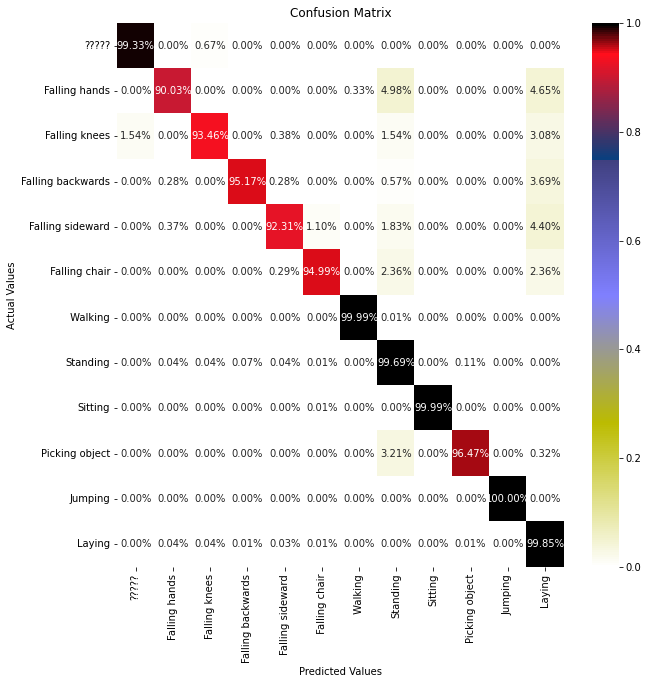

[0.9933, 0.9003, 0.9346, 0.9517, 0.9231, 0.9499, 0.9999, 0.9969, 0.9999, 0.9647, 1.0, 0.9985]


In [ ]:
ss = 'average'

model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
                           all_list_filters_0 = [[32], [32],[32],[32],[32]], 
                           all_list_filters_1 =  [[32],
                                                  [32,28],
                                                  [32,28,24],
                                                  [32,28,24,24],
                                                  [32,28,24,24,20],
                                                  [32,28,24,24,20,20]], 
                           list_num_experts_0 = 5, 
                           list_num_experts_1 = 6, 
                           same_seed = [False,True],
                           method = ss)
# model_concat_12.summary()

# LOAD OUR PRE-TRAINED WEIGHT 

model_concat_12.compile(

                 optimizer = tf.keras.optimizers.Adadelta(learning_rate= 1, rho=0.95, epsilon=1e-08, decay=0.0),
                 loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
                 metrics = [
                            keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
                            keras.metrics.Precision(name='precision'),
                            keras.metrics.Recall(name='recall'),
                            tfa.metrics.F1Score( num_classes=12,   
                                                name = 'f1_score',
                                                average='weighted') 
                 ])



print("best model: ")
path  = "/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/raw_" + ss  + '.hdf5'

model_concat_12.load_weights(path)
print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
display_result(y_val_2, y_val)

print('*'*20)
y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
display_result(y_test_2, y_test)
dd = draw_cm(y_test_2,y_test)
print(dd)

In [ ]:

# UNCOMMENT IF U WANT TO TRAIN THE MODEL

# model_concat_12 = model_2concat_gating(shape1 = 32, shape2 = 32 , 
#                            all_list_filters_0 = [[32], [32],[32],[32],[32]], 
#                            all_list_filters_1 =  [[32],
#                                                   [32,28],
#                                                   [32,28,24],
#                                                   [32,28,24,24],
#                                                   [32,28,24,24,20],
#                                                   [32,28,24,24,20,20]], 
#                            list_num_experts_0 = 5, 
#                            list_num_experts_1 = 6, 
#                            same_seed = [False,True],
#                            method = 'average')
# model_concat_12.summary()


# model_concat_12.compile(

#                  optimizer = tf.keras.optimizers.Adadelta(learning_rate= 0.95, rho=0.95, epsilon=1e-08, decay=0.0),
#                  loss = keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),
#                  metrics = [
#                             keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#                             keras.metrics.Precision(name='precision'),
#                             keras.metrics.Recall(name='recall'),
#                             tfa.metrics.F1Score( num_classes=12,   
#                                                 name = 'f1_score',
#                                                 average='weighted') 
#                  ])

# filepath = 'Saved Model/New_1/gating_img12_3_a_1.hdf5'
# f1_callback1 = ModelCheckpoint(filepath, 
#                               monitor='val_f1_score', 
#                               verbose=1, 
#                               save_best_only=True,
#                               mode='max')


# print("best model: ")
# model_concat_12.load_weights("/content/drive/MyDrive/Colab Notebooks/Journal/Saved Model/raw_average.hdf5")
# print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
# print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


# y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
# display_result(y_val_2, y_val)

# print('*'*20)
# y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
# display_result(y_test_2, y_test)



# print("best model: ")
# model_concat_12.load_weights("Saved Model/New_1/gating_img12_3_a_1.hdf5")
# print(model_concat_12.evaluate([X_val_1_scaled,X_val_2_scaled] , Y_val_2))
# print(model_concat_12.evaluate([X_test_1_scaled,X_test_2_scaled] , Y_test_2))


# y_val = np.argmax(model_concat_12.predict([X_val_1_scaled,X_val_2_scaled]), axis = 1 )
# display_result(y_val_2, y_val)

# print('*'*20)
# y_test = np.argmax(model_concat_12.predict([X_test_1_scaled,X_test_2_scaled]), axis = 1 )
# display_result(y_test_2, y_test)

In [ ]:
list(f1_score(y_test_2, y_test, average=None))

[0.9899665551839465,
 0.9264957264957264,
 0.9436893203883495,
 0.9612625538020086,
 0.9368029739776952,
 0.9640718562874252,
 0.9998957355854446,
 0.9964841346576426,
 0.9999472323360244,
 0.9616613418530351,
 1.0,
 0.9972920427718373]